# Cắt dữ liệu SMAP TIFF theo khu vực nghiên cứu Hoa Lac

Notebook này được tạo để cắt các file TIFF của dữ liệu độ ẩm đất SMAP theo ranh giới khu vực nghiên cứu được định nghĩa bởi shapefile Hoa Lac.

## Mục tiêu:
- Đọc và xử lý shapefile ranh giới khu vực nghiên cứu
- Cắt dữ liệu TIFF theo ranh giới này
- Xử lý hàng loạt tất cả các file TIFF trong thư mục
- Lưu kết quả và trực quan hóa dữ liệu

## 1. Import các thư viện cần thiết

In [1]:
# Import các thư viện cần thiết
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Thư viện xử lý dữ liệu không gian
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

print("Đã import thành công tất cả thư viện!")

Đã import thành công tất cả thư viện!


## 2. Định nghĩa đường dẫn và tải shapefile

In [2]:
# Định nghĩa đường dẫn
base_path = "/Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data"

# Đường dẫn đến shapefile khu vực nghiên cứu
shapefile_path = os.path.join(base_path, "Shapefile", "hoa_lac.shp")

# Đường dẫn đến thư mục chứa file TIFF
tiff_folder = os.path.join(base_path, "SMAP-Derived 1-km Downscaled Surface Soil Moisture Product V001", "NSIDC-0779_1-20250912_154614")

# Tạo thư mục output để lưu kết quả
output_folder = os.path.join(base_path, "SMAP-Derived 1-km Downscaled Surface Soil Moisture Product V001", "clipped_tiffs")
os.makedirs(output_folder, exist_ok=True)

print(f"Đường dẫn shapefile: {shapefile_path}")
print(f"Đường dẫn thư mục TIFF: {tiff_folder}")
print(f"Đường dẫn thư mục output: {output_folder}")

Đường dẫn shapefile: /Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/Shapefile/hoa_lac.shp
Đường dẫn thư mục TIFF: /Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/SMAP-Derived 1-km Downscaled Surface Soil Moisture Product V001/NSIDC-0779_1-20250912_154614
Đường dẫn thư mục output: /Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/SMAP-Derived 1-km Downscaled Surface Soil Moisture Product V001/clipped_tiffs


In [3]:
# Tải shapefile khu vực nghiên cứu
try:
    study_area = gpd.read_file(shapefile_path)
    print("Đã tải thành công shapefile!")
    print(f"Số lượng polygon: {len(study_area)}")
    print(f"Hệ tọa độ: {study_area.crs}")
    print(f"Bounds: {study_area.bounds}")
    
    # Hiển thị thông tin chi tiết
    print("\nThông tin shapefile:")
    print(study_area.info())
    
except Exception as e:
    print(f"Lỗi khi tải shapefile: {e}")

Đã tải thành công shapefile!
Số lượng polygon: 1
Hệ tọa độ: EPSG:4326
Bounds:          minx      miny        maxx       maxy
0  105.461495  20.97794  105.556537  21.048272

Thông tin shapefile:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ma_xa      1 non-null      object  
 1   ten_xa     1 non-null      object  
 2   sap_nhap   1 non-null      object  
 3   tru_so     1 non-null      object  
 4   loai       1 non-null      object  
 5   cap        1 non-null      int32   
 6   stt        1 non-null      int32   
 7   dtich_km2  1 non-null      float64 
 8   dan_so     1 non-null      int32   
 9   matdo_km2  1 non-null      float64 
 10  ma_tinh    1 non-null      object  
 11  ten_tinh   1 non-null      object  
 12  geometry   1 non-null      geometry
dtypes: float64(2), geometry(1), int32(3), object(7)
memory usage: 220.0+ bytes
No

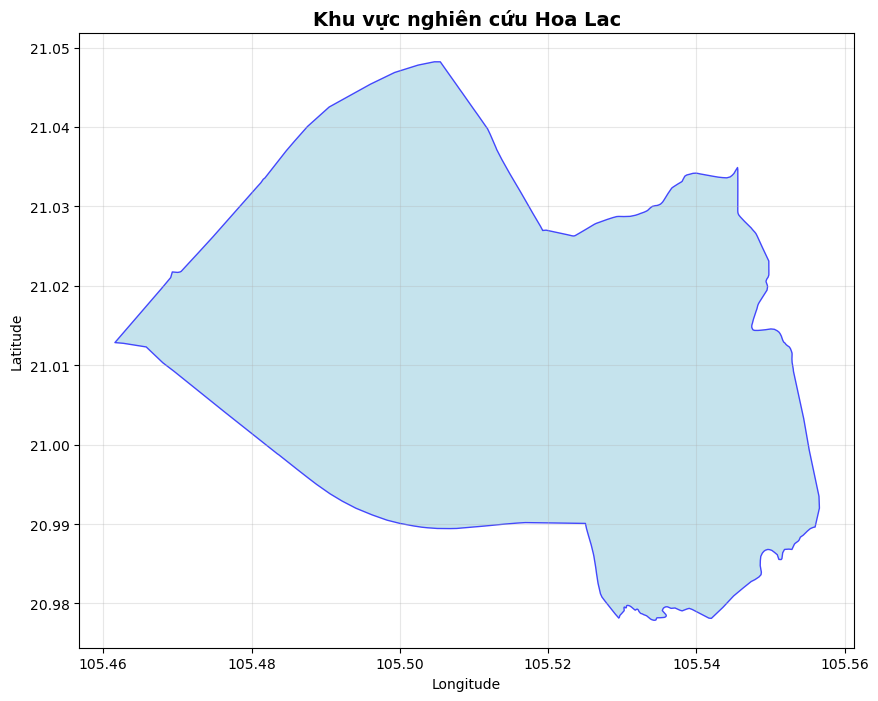

Khu vực nghiên cứu đã được hiển thị trên bản đồ.


In [4]:
# Hiển thị shapefile trên bản đồ
fig, ax = plt.subplots(figsize=(10, 8))
study_area.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.7)
ax.set_title('Khu vực nghiên cứu Hoa Lac', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

print("Khu vực nghiên cứu đã được hiển thị trên bản đồ.")

## 3. Đọc và kiểm tra file TIFF mẫu

In [5]:
# Lấy danh sách tất cả file TIFF
tiff_files = glob.glob(os.path.join(tiff_folder, "*.tif"))
tiff_files = [f for f in tiff_files if not f.endswith('.aux.xml')]  # Loại bỏ file metadata
tiff_files.sort()

print(f"Tìm thấy {len(tiff_files)} file TIFF")
print("5 file đầu tiên:")
for i, file in enumerate(tiff_files[:5]):
    print(f"{i+1}. {os.path.basename(file)}")

# Chọn file đầu tiên để kiểm tra
sample_tiff = tiff_files[0]
print(f"\nĐang kiểm tra file mẫu: {os.path.basename(sample_tiff)}")

Tìm thấy 31 file TIFF
5 file đầu tiên:
1. NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
2. NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230602.tif
3. NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230603.tif
4. NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230604.tif
5. NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230605.tif

Đang kiểm tra file mẫu: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif


In [6]:
# Đọc file TIFF mẫu và kiểm tra thông tin
with rasterio.open(sample_tiff) as src:
    print("=== THÔNG TIN FILE TIFF ===")
    print(f"Tên file: {os.path.basename(sample_tiff)}")
    print(f"Kích thước: {src.width} x {src.height}")
    print(f"Số band: {src.count}")
    print(f"Kiểu dữ liệu: {src.dtypes}")
    print(f"Hệ tọa độ: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"Transform: {src.transform}")
    print(f"NoData value: {src.nodata}")
    
    # Đọc dữ liệu
    data = src.read(1)
    print(f"\nThông tin dữ liệu:")
    print(f"Shape: {data.shape}")
    print(f"Min value: {np.nanmin(data)}")
    print(f"Max value: {np.nanmax(data)}")
    print(f"Mean value: {np.nanmean(data)}")
    print(f"Số pixel có dữ liệu: {np.sum(~np.isnan(data))}")
    print(f"Số pixel NoData: {np.sum(np.isnan(data))}")

=== THÔNG TIN FILE TIFF ===
Tên file: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
Kích thước: 34704 x 14616
Số band: 2
Kiểu dữ liệu: ('float32', 'float32')
Hệ tọa độ: EPSG:6933
Bounds: BoundingBox(left=-17367530.44516138, bottom=-7314540.868694279, right=17367530.445161752, top=7314540.79258289)
Transform: | 1000.90, 0.00,-17367530.45|
| 0.00,-1000.90, 7314540.79|
| 0.00, 0.00, 1.00|
NoData value: 0.0

Thông tin dữ liệu:
Shape: (14616, 34704)

Thông tin dữ liệu:
Shape: (14616, 34704)
Min value: 1.7695128917694092e-07
Max value: 1.0461881160736084
Min value: 1.7695128917694092e-07
Max value: 1.0461881160736084
Mean value: 0.20494186878204346
Mean value: 0.20494186878204346
Số pixel có dữ liệu: 48381797
Số pixel có dữ liệu: 48381797
Số pixel NoData: 458851867
Số pixel NoData: 458851867


## 4. Tạo hàm cắt TIFF theo shapefile

In [7]:
def clip_tiff_by_shapefile(tiff_path, shapefile_gdf, output_path):
    """
    Cắt file TIFF theo ranh giới shapefile
    
    Parameters:
    -----------
    tiff_path : str
        Đường dẫn đến file TIFF input
    shapefile_gdf : geopandas.GeoDataFrame
        GeoDataFrame chứa ranh giới cắt
    output_path : str
        Đường dẫn file TIFF output
        
    Returns:
    --------
    bool
        True nếu thành công, False nếu có lỗi
    """
    try:
        # Mở file TIFF
        with rasterio.open(tiff_path) as src:
            
            # Chuyển đổi hệ tọa độ của shapefile nếu cần
            if shapefile_gdf.crs != src.crs:
                print(f"Chuyển đổi hệ tọa độ từ {shapefile_gdf.crs} sang {src.crs}")
                shapefile_reprojected = shapefile_gdf.to_crs(src.crs)
            else:
                shapefile_reprojected = shapefile_gdf
            
            # Lấy geometry để cắt
            shapes = [mapping(geom) for geom in shapefile_reprojected.geometry]
            
            # Thực hiện cắt
            clipped_data, clipped_transform = mask(src, shapes, crop=True)
            clipped_meta = src.meta.copy()
            
            # Cập nhật metadata
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_data.shape[1],
                "width": clipped_data.shape[2], 
                "transform": clipped_transform,
                "compress": "lzw"  # Nén để tiết kiệm dung lượng
            })
            
            # Lưu file đã cắt
            with rasterio.open(output_path, "w", **clipped_meta) as dest:
                dest.write(clipped_data)
            
            print(f"✓ Đã cắt thành công: {os.path.basename(tiff_path)}")
            return True
            
    except Exception as e:
        print(f"✗ Lỗi khi cắt {os.path.basename(tiff_path)}: {str(e)}")
        return False

print("Hàm clip_tiff_by_shapefile đã được tạo thành công!")

Hàm clip_tiff_by_shapefile đã được tạo thành công!


## 5. Kiểm tra hàm cắt với file mẫu

In [8]:
# Kiểm tra hàm cắt với file mẫu
test_output = os.path.join(output_folder, "test_" + os.path.basename(sample_tiff))

print("Đang kiểm tra hàm cắt với file mẫu...")
print(f"File input: {os.path.basename(sample_tiff)}")
print(f"File output: {os.path.basename(test_output)}")

# Thực hiện cắt
success = clip_tiff_by_shapefile(sample_tiff, study_area, test_output)

if success and os.path.exists(test_output):
    print("\n=== KIỂM TRA KẾT QUẢ ===")
    
    # So sánh trước và sau khi cắt
    with rasterio.open(sample_tiff) as original:
        with rasterio.open(test_output) as clipped:
            print(f"Kích thước gốc: {original.width} x {original.height}")
            print(f"Kích thước sau cắt: {clipped.width} x {clipped.height}")
            print(f"Bounds gốc: {original.bounds}")
            print(f"Bounds sau cắt: {clipped.bounds}")
            
            # Đọc dữ liệu để so sánh
            original_data = original.read(1)
            clipped_data = clipped.read(1)
            
            print(f"Số pixel có dữ liệu (gốc): {np.sum(~np.isnan(original_data))}")
            print(f"Số pixel có dữ liệu (sau cắt): {np.sum(~np.isnan(clipped_data))}")
            
            # Tính tỷ lệ giảm
            reduction_ratio = (clipped.width * clipped.height) / (original.width * original.height)
            print(f"Tỷ lệ kích thước sau cắt: {reduction_ratio:.2%}")
else:
    print("Kiểm tra thất bại!")

Đang kiểm tra hàm cắt với file mẫu...
File input: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
File output: test_NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
Chuyển đổi hệ tọa độ từ EPSG:4326 sang EPSG:6933
✓ Đã cắt thành công: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif

=== KIỂM TRA KẾT QUẢ ===
Kích thước gốc: 34704 x 14616
Kích thước sau cắt: 10 x 10
Bounds gốc: BoundingBox(left=-17367530.44516138, bottom=-7314540.868694279, right=17367530.445161752, top=7314540.79258289)
Bounds sau cắt: BoundingBox(left=10175098.807371814, bottom=2617340.448003405, right=10185107.757605309, top=2627349.3982369006)
Số pixel có dữ liệu (gốc): 48381797
Số pixel có dữ liệu (sau cắt): 55
Tỷ lệ kích thước sau cắt: 0.00%
Số pixel có dữ liệu (gốc): 48381797
Số pixel có dữ liệu (sau cắt): 55
Tỷ lệ kích thước sau cắt: 0.00%


## 6. Xử lý hàng loạt tất cả file TIFF

In [ ]:
# Xử lý hàng loạt tất cả file TIFF
import time

print(f"Bắt đầu xử lý {len(tiff_files)} file TIFF...")
print(f"Thư mục output: {output_folder}")

# Thống kê
successful_files = []
failed_files = []
start_time = time.time()

# Xử lý từng file
for i, tiff_file in enumerate(tiff_files):
    # Hiển thị tiến trình
    print(f"Đang xử lý file {i+1}/{len(tiff_files)}: {os.path.basename(tiff_file)}")
    
    # Tạo tên file output
    base_name = os.path.basename(tiff_file)
    output_name = f"clipped_{base_name}"
    output_path = os.path.join(output_folder, output_name)
    
    # Bỏ qua nếu file đã tồn tại
    if os.path.exists(output_path):
        print(f"  ➤ Bỏ qua (đã tồn tại): {base_name}")
        successful_files.append(base_name)
        continue
    
    # Thực hiện cắt
    success = clip_tiff_by_shapefile(tiff_file, study_area, output_path)
    
    if success:
        successful_files.append(base_name)
    else:
        failed_files.append(base_name)

# Thống kê kết quả
end_time = time.time()
processing_time = end_time - start_time

print("\n" + "="*50)
print("KẾT QUẢ XỬ LÝ HÀNG LOẠT")
print("="*50)
print(f"Tổng số file: {len(tiff_files)}")
print(f"Thành công: {len(successful_files)}")
print(f"Thất bại: {len(failed_files)}")
print(f"Tỷ lệ thành công: {len(successful_files)/len(tiff_files)*100:.1f}%")
print(f"Thời gian xử lý: {processing_time:.2f} giây")
print(f"Thời gian trung bình/file: {processing_time/len(tiff_files):.2f} giây")

if failed_files:
    print(f"\nCác file thất bại:")
    for file in failed_files:
        print(f"  - {file}")

Bắt đầu xử lý 31 file TIFF...
Thư mục output: /Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/SMAP-Derived 1-km Downscaled Surface Soil Moisture Product V001/clipped_tiffs
Đang xử lý file 1/31: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
  ➤ Bỏ qua (đã tồn tại): NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230601.tif
Đang xử lý file 2/31: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230602.tif
  ➤ Bỏ qua (đã tồn tại): NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230602.tif
Đang xử lý file 3/31: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230603.tif
  ➤ Bỏ qua (đã tồn tại): NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230603.tif
Đang xử lý file 4/31: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230604.tif
  ➤ Bỏ qua (đã tồn tại): NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230604.tif
Đang xử lý file 5/31: NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230605.tif
  ➤ Bỏ qua (đã tồn tại): NSIDC-0779_EASE2_G1km_SMAP_SM_DS_20230605.tif
Đang xử lý file 6/31: NSIDC-0779

: 

## 7. Trực quan hóa kết quả

In [ ]:
# So sánh trước và sau khi cắt
def visualize_comparison(original_file, clipped_file, study_area_gdf):
    """Hiển thị so sánh dữ liệu trước và sau khi cắt"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Dữ liệu gốc
    with rasterio.open(original_file) as src:
        original_data = src.read(1)
        # Thay thế giá trị NoData bằng NaN
        original_data = np.where(original_data == src.nodata, np.nan, original_data)
        
        im1 = axes[0].imshow(original_data, cmap='Blues', vmin=0, vmax=0.5)
        axes[0].set_title('Dữ liệu gốc (Toàn cầu)', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Pixel X')
        axes[0].set_ylabel('Pixel Y')
        
        # Thêm colorbar
        cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
        cbar1.set_label('Độ ẩm đất (m³/m³)', rotation=270, labelpad=20)
    
    # Plot 2: Dữ liệu đã cắt
    with rasterio.open(clipped_file) as src:
        clipped_data = src.read(1)
        clipped_data = np.where(clipped_data == src.nodata, np.nan, clipped_data)
        
        im2 = axes[1].imshow(clipped_data, cmap='Blues', vmin=0, vmax=0.5)
        axes[1].set_title('Dữ liệu đã cắt (Khu vực Hoa Lac)', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Pixel X')
        axes[1].set_ylabel('Pixel Y')
        
        cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
        cbar2.set_label('Độ ẩm đất (m³/m³)', rotation=270, labelpad=20)
    
    # Plot 3: Ranh giới khu vực nghiên cứu
    study_area_gdf.plot(ax=axes[2], color='lightcoral', edgecolor='red', alpha=0.7, linewidth=2)
    axes[2].set_title('Ranh giới khu vực nghiên cứu', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Longitude')
    axes[2].set_ylabel('Latitude')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Kiểm tra và hiển thị so sánh nếu có file test
if os.path.exists(test_output):
    print("Hiển thị so sánh dữ liệu trước và sau khi cắt:")
    visualize_comparison(sample_tiff, test_output, study_area)
else:
    print("Không tìm thấy file test để hiển thị so sánh")

Hiển thị so sánh dữ liệu trước và sau khi cắt:


In [ ]:
# Phân tích chuỗi thời gian độ ẩm đất
def analyze_time_series():
    """Phân tích chuỗi thời gian độ ẩm đất từ các file đã cắt"""
    
    # Lấy danh sách file đã cắt
    clipped_files = glob.glob(os.path.join(output_folder, "clipped_*.tif"))
    clipped_files.sort()
    
    if len(clipped_files) == 0:
        print("Không tìm thấy file đã cắt nào!")
        return
    
    print(f"Phân tích chuỗi thời gian từ {len(clipped_files)} file...")
    
    # Trích xuất ngày tháng và giá trị trung bình
    dates = []
    mean_values = []
    
    for file in clipped_files:
        # Trích xuất ngày từ tên file
        basename = os.path.basename(file)
        date_str = basename.split('_')[-1].replace('.tif', '')  # Lấy phần ngày
        try:
            date = datetime.strptime(date_str, '%Y%m%d')
            dates.append(date)
            
            # Đọc dữ liệu và tính giá trị trung bình
            with rasterio.open(file) as src:
                data = src.read(1)
                data = np.where(data == src.nodata, np.nan, data)
                mean_val = np.nanmean(data)
                mean_values.append(mean_val)
                
        except Exception as e:
            print(f"Lỗi xử lý file {basename}: {e}")
            continue
    
    # Tạo DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Mean_Soil_Moisture': mean_values
    })
    df = df.sort_values('Date')
    
    # Vẽ biểu đồ chuỗi thời gian
    plt.figure(figsize=(15, 8))
    
    # Subplot 1: Chuỗi thời gian
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Mean_Soil_Moisture'], 'b-o', linewidth=2, markersize=4)
    plt.title('Chuỗi thời gian độ ẩm đất trung bình - Khu vực Hoa Lac', fontsize=14, fontweight='bold')
    plt.xlabel('Ngày')
    plt.ylabel('Độ ẩm đất trung bình (m³/m³)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Thêm thống kê cơ bản
    mean_moisture = df['Mean_Soil_Moisture'].mean()
    std_moisture = df['Mean_Soil_Moisture'].std()
    plt.axhline(y=mean_moisture, color='r', linestyle='--', alpha=0.7, 
                label=f'Trung bình: {mean_moisture:.4f}')
    plt.axhline(y=mean_moisture + std_moisture, color='orange', linestyle='--', alpha=0.7, 
                label=f'TB + 1σ: {mean_moisture + std_moisture:.4f}')
    plt.axhline(y=mean_moisture - std_moisture, color='orange', linestyle='--', alpha=0.7,
                label=f'TB - 1σ: {mean_moisture - std_moisture:.4f}')
    plt.legend()
    
    # Subplot 2: Histogram
    plt.subplot(2, 1, 2)
    plt.hist(df['Mean_Soil_Moisture'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Phân phối độ ẩm đất trung bình', fontsize=14, fontweight='bold')
    plt.xlabel('Độ ẩm đất trung bình (m³/m³)')
    plt.ylabel('Tần suất')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # In thống kê
    print("\n=== THỐNG KÊ CHUỖI THỜI GIAN ===")
    print(f"Thời gian: {df['Date'].min().strftime('%Y-%m-%d')} đến {df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Số điểm dữ liệu: {len(df)}")
    print(f"Độ ẩm đất trung bình: {mean_moisture:.6f} m³/m³")
    print(f"Độ lệch chuẩn: {std_moisture:.6f} m³/m³")
    print(f"Giá trị min: {df['Mean_Soil_Moisture'].min():.6f} m³/m³")
    print(f"Giá trị max: {df['Mean_Soil_Moisture'].max():.6f} m³/m³")
    
    return df

# Chạy phân tích chuỗi thời gian
time_series_df = analyze_time_series()

## 8. Tóm tắt và kết luận

In [ ]:
# Tóm tắt quá trình xử lý
print("="*60)
print("TÓM TẮT QUÁ TRÌNH XỬ LÝ")
print("="*60)

print("\n✓ HOÀN THÀNH CÁC BƯỚC:")
print("  1. Tải và kiểm tra shapefile khu vực nghiên cứu Hoa Lac")
print("  2. Đọc và phân tích dữ liệu TIFF SMAP gốc")
print("  3. Tạo hàm cắt dữ liệu TIFF theo ranh giới shapefile")
print("  4. Kiểm tra hàm với file mẫu")
print("  5. Xử lý hàng loạt tất cả file TIFF")
print("  6. Trực quan hóa kết quả và phân tích chuỗi thời gian")

print(f"\n📁 CÁC THÔNG TIN QUAN TRỌNG:")
print(f"  • Thư mục dữ liệu gốc: {tiff_folder}")
print(f"  • Thư mục kết quả: {output_folder}")
print(f"  • Shapefile ranh giới: {shapefile_path}")

# Kiểm tra kết quả cuối cùng
output_files = glob.glob(os.path.join(output_folder, "clipped_*.tif"))
print(f"\n📊 KẾT QUẢ CUỐI CÙNG:")
print(f"  • Số file TIFF đã cắt: {len(output_files)}")
print(f"  • Dung lượng thư mục output: {sum(os.path.getsize(f) for f in output_files) / 1024 / 1024:.1f} MB")

print(f"\n🎯 CÁCH SỬ DỤNG:")
print("  • Các file TIFF đã cắt có thể được sử dụng cho phân tích chi tiết")
print("  • Có thể tích hợp với các dữ liệu khác (CHIRPS, Sentinel, etc.)")
print("  • Thích hợp cho nghiên cứu về độ ẩm đất tại khu vực Hoa Lac")

print(f"\n💡 GHI CHÚ:")
print("  • Hệ tọa độ được tự động chuyển đổi khi cần thiết")
print("  • File được nén LZW để tiết kiệm dung lượng")
print("  • Metadata gốc được bảo toàn trong file output")
print("  • Có thể chạy lại notebook mà không bị lỗi (skip file đã tồn tại)")

print("\n" + "="*60)
print("XỬ LÝ HOÀN TẤT THÀNH CÔNG! 🎉")
print("="*60)